# Environment setup

In [1]:
# Import required libraries
import loompy
import numpy as np
import pandas as pd
import gc  # for garbage collection
import os
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, List
import warnings
warnings.filterwarnings('ignore')

# Set working directory
os.chdir('/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SRRM3_dev/Mousebrain')

# Set plotting style
plt.style.use('default')  # Use default matplotlib style
sns.set_theme()  # Apply seaborn styling
sns.set_palette("husl")

# Create plots directory if it doesn't exist
plots_dir = 'plots_clusters'
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

In [2]:
loom_path = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SRRM3_dev/Mousebrain/DATA/dev_all.agg.loom"

In [3]:
# Verify file exists
print(f"File exists: {os.path.exists(loom_path)}")
print(f"File size: {os.path.getsize(loom_path) / (1024**3):.2f} GB")

File exists: True
File size: 0.28 GB


# Functions definitions

In [4]:
# Function to get age from column name
def extract_age(age_col):
    return float(age_col.replace('Age_e', '').replace('_0', '').replace('_', '.'))

In [5]:
def extract_expression_data(loom_path: str, gene: str = 'Srrm3', tissues: List[str] = ['Tissue_ForebrainDorsal']) -> List[Dict]:
    """
    Extract expression data for a given gene from loom file, focusing on specific tissue regions.
    
    Args:
        loom_path: Path to the loom file
        gene: Gene name to analyze (default: 'Srrm3')
        tissues: List of tissue column names to filter on (default: ['Tissue_ForebrainDorsal'])
        
    Returns:
        List of dictionaries containing age and expression data for each cell
    """
    # Connect to the loom file
    with loompy.connect(loom_path) as ds:
        # Find gene index
        gene_idx = np.where(ds.ra['Gene'] == gene)[0]
        if len(gene_idx) == 0:
            raise ValueError(f"{gene} gene not found in the dataset")
        
        # Get gene expression data
        gene_expression = ds[gene_idx[0], :]
        
        # Get age columns
        age_cols = [col for col in ds.ca.keys() if col.startswith('Age_e')]
        
        # Create a dictionary to store age and expression data
        age_expression_data = []
        
        # For each cell
        for cell_idx in range(ds.shape[1]):
            # Check if cell belongs to any of the specified tissues
            if any(ds.ca[tissue][cell_idx] == 1 for tissue in tissues):
                # Find which age this cell belongs to
                cell_age = None
                for age_col in age_cols:
                    if ds.ca[age_col][cell_idx] == 1:
                        cell_age = extract_age(age_col)
                        break
                
                if cell_age is not None:
                    age_expression_data.append({
                        'Age': cell_age,
                        'Expression': gene_expression[cell_idx],
                        'Cluster': ds.ca['ClusterName'][cell_idx],
                        'Class': ds.ca['Class'][cell_idx],
                        'Subclass': ds.ca['Subclass'][cell_idx],
                        'Tissue': [tissue for tissue in tissues if ds.ca[tissue][cell_idx] == 1][0]
                    })
                    
    return age_expression_data

In [6]:
def examine_loom_file(loom_path: str) -> None:
    """
    Examine and print basic information about a loom file.
    
    Args:
        loom_path: Path to the loom file
    """
    # Connect to the loom file (this doesn't load it entirely into memory)
    with loompy.connect(loom_path) as ds:
        # Basic information about the dataset
        print("\nDataset shape:", ds.shape)
        print(f"Number of cells: {ds.shape[1]:,}")
        print(f"Number of genes: {ds.shape[0]:,}")
        
        # Examine column attributes (cell metadata)
        print("\nColumn attributes (cell metadata):")
        for attr in ds.ca.keys():
            print(f"- {attr}: {ds.ca[attr].dtype}")
        
        # Examine row attributes (gene metadata)
        print("\nRow attributes (gene metadata):")
        for attr in ds.ra.keys():
            print(f"- {attr}: {ds.ra[attr].dtype}")
        
        # Get a small sample of the expression matrix (first 5 genes, first 5 cells)
        print("\nSample of expression matrix (5x5):")
        sample_matrix = ds[:5, :5]
        print(sample_matrix)
        
        # Get some basic statistics
        print("\nBasic statistics:")
        print(f"Mean expression: {np.mean(sample_matrix):.4f}")
        print(f"Median expression: {np.median(sample_matrix):.4f}")
        print(f"Sparsity: {(sample_matrix == 0).sum() / sample_matrix.size:.2%}")

    # Force garbage collection
    gc.collect()

# Data exploration

In [7]:
examine_loom_file(loom_path)


Dataset shape: (31053, 798)
Number of cells: 798
Number of genes: 31,053

Column attributes (cell metadata):
- Age_e10_0: int64
- Age_e11_0: int64
- Age_e12_0: int64
- Age_e12_5: int64
- Age_e13_0: int64
- Age_e13_5: int64
- Age_e14_0: int64
- Age_e14_5: int64
- Age_e15_0: int64
- Age_e15_5: int64
- Age_e16_0: int64
- Age_e16_25: int64
- Age_e16_5: int64
- Age_e17_0: int64
- Age_e17_5: int64
- Age_e18_0: int64
- Age_e7_0: int64
- Age_e8_0: int64
- Age_e8_5: int64
- Age_e9_0: int64
- AutoAnnotation: object
- Class: object
- ClusterName: object
- Clusters: int64
- Location_E9_E11: object
- MarkerGenes: object
- MarkerRobustness: object
- MarkerSelectivity: object
- MarkerSpecificity: object
- NCells: int64
- Outliers: float64
- SampleID_10X08_1: int64
- SampleID_10X10_2: int64
- SampleID_10X10_3: int64
- SampleID_10X12_2: int64
- SampleID_10X12_3: int64
- SampleID_10X12_4: int64
- SampleID_10X13_4: int64
- SampleID_10X13_5: int64
- SampleID_10X14_2: int64
- SampleID_10X14_3: int64
- Sam

**Available tissues:**

- Tissue_All: int64
- Tissue_Forebrain: int64
- Tissue_ForebrainDorsal: int64
- Tissue_ForebrainVentral: int64
- Tissue_ForebrainVentroLateral: int64
- Tissue_ForebrainVentroThalamic: int64
- Tissue_Head: int64
- Tissue_Hindbrain: int64
- Tissue_Midbrain: int64
- Tissue_MidbrainDorsal: int64
- Tissue_MidbrainVentral: int64

## Expression format

In [16]:
ds = loompy.connect(loom_path)
matrix = ds[:, :]
print("Matrix shape:", matrix.shape)
print("Value range:", np.min(matrix), "-", np.max(matrix))
print("Zero proportion:", np.sum(matrix == 0) / matrix.size)
print("Mean expression:", np.mean(matrix))
print("Mean expression (excluding zeros):", np.mean(matrix[matrix > 0]))


Matrix shape: (31053, 798)
Value range: 0.0 - 7071.009360374415
Zero proportion: 0.5449784009826518
Mean expression: 0.22687010231067037
Mean expression (excluding zeros): 0.49859194113117483


Text(0, 0.5, 'Count')

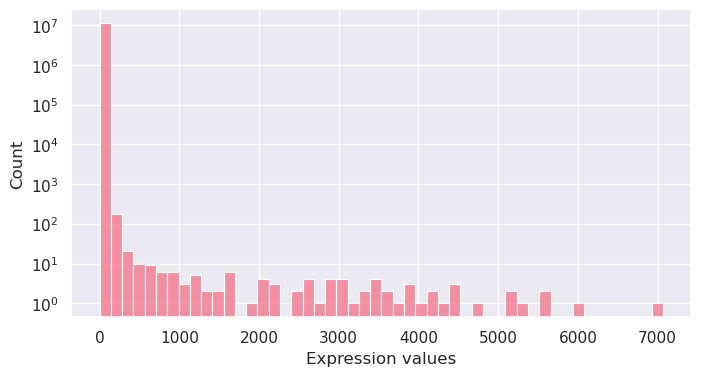

In [10]:
plt.figure(figsize=(8,4))
sns.histplot(matrix[matrix > 0].flatten(), bins=50, log=True)
plt.xlabel('Expression values')
plt.ylabel('Count')

Mean Srrm3 expression (excluding zeros): 0.450


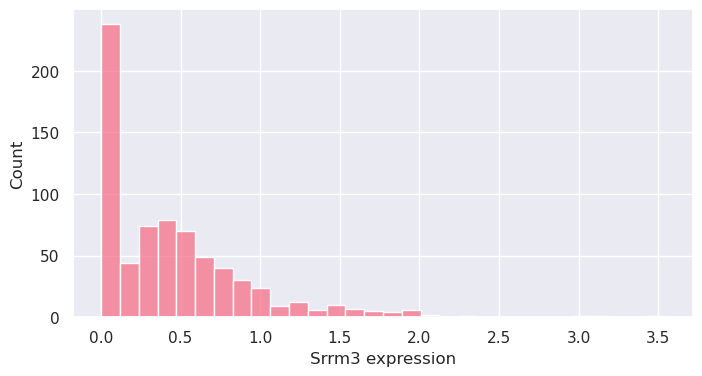

In [17]:
# Get Srrm3 index
srrm3_idx = np.where(ds.ra.Gene == 'Srrm3')[0][0]
srrm3_expr = matrix[srrm3_idx, :]

plt.figure(figsize=(8,4))
sns.histplot(srrm3_expr[srrm3_expr > 0], bins=30)
plt.xlabel('Srrm3 expression')
plt.ylabel('Count')

# Calculate mean expression excluding zeros
srrm3_mean_nonzero = np.mean(srrm3_expr[srrm3_expr > 0])
print(f"Mean Srrm3 expression (excluding zeros): {srrm3_mean_nonzero:.3f}")

In [14]:
# Calculate proportion of non-zero expression
srrm3_expressed = np.sum(srrm3_expr > 0) / len(srrm3_expr)
print(f"Srrm3 is expressed in {srrm3_expressed:.2%} of samples")

Srrm3 is expressed in 89.35% of samples


In [45]:
age_expression_data = extract_expression_data(loom_path, tissues=['Tissue_ForebrainDorsal'])

# Convert to DataFrame
df = pd.DataFrame(age_expression_data)
print(df.shape)

(58, 6)


In [43]:
df.head()

,Age,Expression,Cluster,Class,Subclass,Tissue
0,18.0,0.015270,Epi1,Gastrulation,Epiblast,Tissue_ForebrainDorsal
1,12.0,0.001156,Mesn8,Mesenchyme,Mesenchyme,Tissue_ForebrainDorsal
2,13.5,0.005780,nan,Neural tube,Optic cup,Tissue_ForebrainDorsal
3,14.0,0.015810,nan,Neural crest,Neural crest,Tissue_ForebrainDorsal
4,13.5,0.000000,NasPitL,Ectoderm,Lateral nasal pit,Tissue_ForebrainDorsal


In [46]:
print(list(df['Class'].unique()))
print(list(df['Subclass'].unique()))
print(list(df['Cluster'].unique()))
print(list(df['Tissue'].unique()))


['Gastrulation', 'Mesenchyme', 'Neural tube', 'Neural crest', 'Ectoderm', 'Blood', 'Fibroblast', 'Vascular', 'Immune', 'Radial glia', 'Choroid plexus', 'Olfactory ensheathing cell', 'Schwann cell', 'Glioblast', 'Neuroblast', 'Neuron']
['Epiblast', 'Mesenchyme', 'Optic cup', 'Neural crest', 'Lateral nasal pit', 'Undefined', 'Pia 1', 'Endothelial', 'Ventral midbrain', 'Midbrain', 'Choroid plexus', 'Spinal cord', 'Hypothalamus', 'Hindbrain', 'Diencephalic roof plate', 'Olfactory ensheathing cell', 'Schwann cell', 'Forebrain', 'Mixed region astrocytes', 'Forebrain GABAergic', 'Mixed region', 'Midbrain glutamatergic', 'Hindbrain glycinergic', 'Hindbrain GABAergic', 'Hindbrain glutamatergic', 'Mixed region and neurotransmitter', 'Mixed region glutamatergic', 'Mixed region GABAergic', 'Forebrain glutamatergic', 'Epithalamus glutamatergic', 'Diencephalon glutamatergic']
['Epi1', 'Mesn8', 'nan', 'NasPitL', 'Pia1', 'Vendo2', 'RglVM2', 'RglM2', 'Chpl4', 'RglSC', 'RglHyp3', 'RglH5', 'RglDERP1', 'O

In [47]:
print(list(df[df['Class'] == 'Gastrulation']["Subclass"].unique()))
print(list(df[df['Class'] == 'Neuron']["Subclass"].unique()))

['Epiblast']
['Forebrain GABAergic', 'Hindbrain glycinergic', 'Hindbrain GABAergic', 'Hindbrain glutamatergic', 'Midbrain glutamatergic', 'Hypothalamus', 'Mixed region', 'Mixed region and neurotransmitter', 'Mixed region glutamatergic', 'Mixed region GABAergic', 'Forebrain glutamatergic', 'Epithalamus glutamatergic', 'Diencephalon glutamatergic']


In [48]:
neuronal_subclasses = list(df[df['Class'] == 'Neuron']["Subclass"].unique())
# Count occurrences of each neuronal subclass
neuronal_subclass_counts = df[df['Class'] == 'Neuron']['Subclass'].value_counts()
print("\nNeuronal subclass counts:")
print(neuronal_subclass_counts)



Neuronal subclass counts:
Subclass
Forebrain GABAergic                  3
Hindbrain glutamatergic              3
Hindbrain GABAergic                  2
Midbrain glutamatergic               2
Hypothalamus                         2
Mixed region glutamatergic           2
Epithalamus glutamatergic            2
Diencephalon glutamatergic           2
Hindbrain glycinergic                1
Mixed region                         1
Mixed region and neurotransmitter    1
Mixed region GABAergic               1
Forebrain glutamatergic              1
Name: count, dtype: int64


In [50]:
# Filter for neuronal lineages (you might need to adjust these filters based on your data)
df['Is_Neuronal'] = df['Class'] == 'Neuron'
df_neurons = df[df['Is_Neuronal']]

In [52]:
df_neurons.head()

,Age,Expression,Cluster,Class,Subclass,Tissue,Is_Neuronal
35,12.0,0.317269,Neur555,Neuron,Forebrain GABAergic,Tissue_ForebrainDorsal,True
36,12.0,0.238095,Neur563,Neuron,Forebrain GABAergic,Tissue_ForebrainDorsal,True
37,18.0,0.612346,Neur596,Neuron,Hindbrain glycinergic,Tissue_ForebrainDorsal,True
38,16.5,0.707237,Neur616,Neuron,Hindbrain GABAergic,Tissue_ForebrainDorsal,True
39,12.5,1.050992,Neur619,Neuron,Hindbrain GABAergic,Tissue_ForebrainDorsal,True


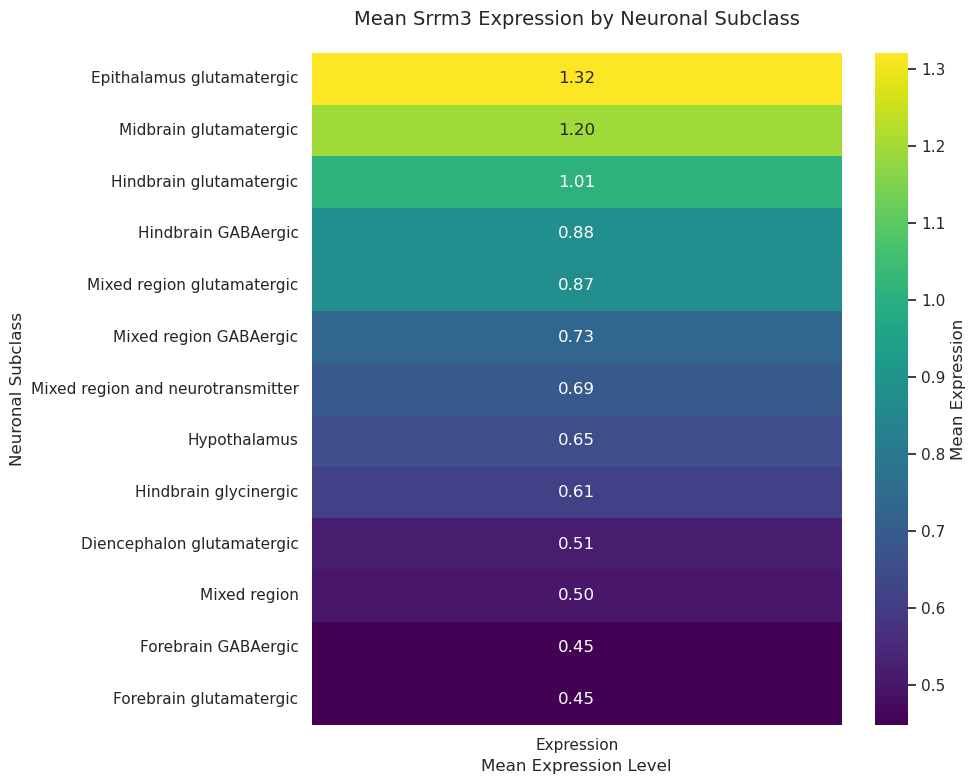

In [59]:
# Aggregate expression data by neuronal subclass
pivot_df = df_neurons.groupby('Subclass')['Expression'].mean().reset_index()

# Sort by expression value and set 'Subclass' as the index
pivot_df = pivot_df.sort_values('Expression', ascending=False)
pivot_df.set_index('Subclass', inplace=True)

# Create the plot
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, 
            cmap='viridis',  
            annot=True,      # Show values in cells
            fmt='.2f',       # Format to 2 decimal places
            cbar_kws={'label': 'Mean Expression'})

# Customize the plot
plt.title('Mean Srrm3 Expression by Neuronal Subclass', fontsize=14, pad=20)
plt.xlabel('Mean Expression Level', fontsize=12)
plt.ylabel('Neuronal Subclass', fontsize=12)

# Adjust layout
plt.tight_layout()

# Save figures
plt.savefig(os.path.join(plots_dir, 'srrm3_cortical_heatmap_no_age.pdf'), 
            bbox_inches='tight', 
            dpi=300)
plt.savefig(os.path.join(plots_dir, 'srrm3_cortical_heatmap_no_age.png'), 
            bbox_inches='tight', 
            dpi=300)

plt.show()

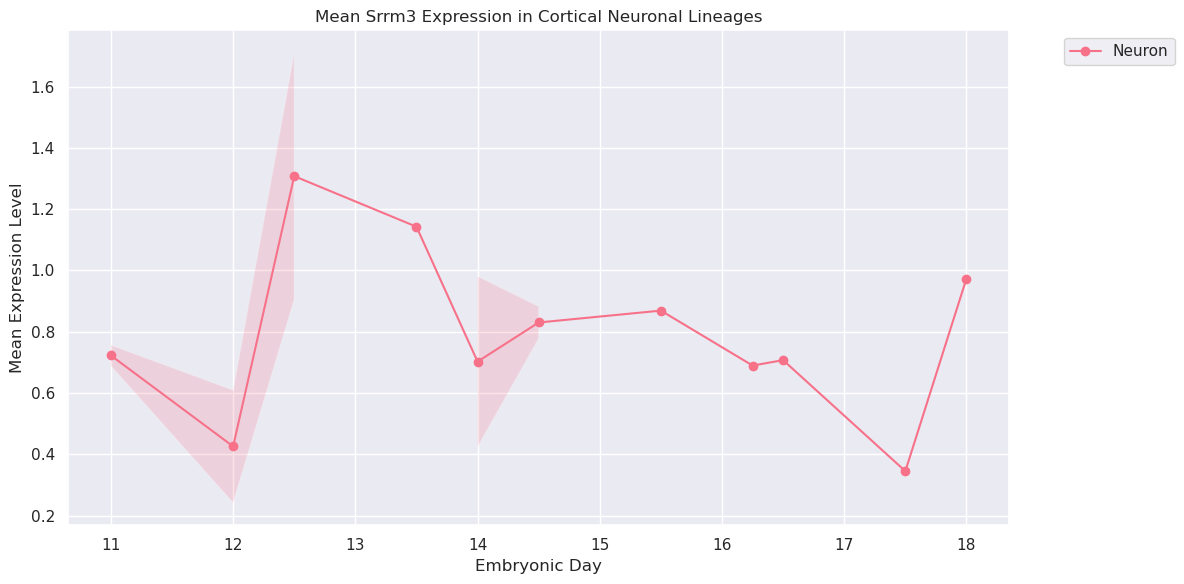

In [60]:
# Calculate mean expression by age and class
mean_by_age_class = df_neurons.groupby(['Age', 'Class'])['Expression'].agg(['mean', 'std']).reset_index()

# Create line plot for different neuronal classes
plt.figure(figsize=(12, 6))
for class_name in mean_by_age_class['Class'].unique():
    class_data = mean_by_age_class[mean_by_age_class['Class'] == class_name]
    plt.plot(class_data['Age'], class_data['mean'], marker='o', label=class_name)
    plt.fill_between(class_data['Age'], 
                    class_data['mean'] - class_data['std'],
                    class_data['mean'] + class_data['std'],
                    alpha=0.2)

plt.title('Mean Srrm3 Expression in Cortical Neuronal Lineages')
plt.xlabel('Embryonic Day')
plt.ylabel('Mean Expression Level')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'srrm3_cortical_lineplot.pdf'), 
            bbox_inches='tight', dpi=300)
plt.savefig(os.path.join(plots_dir, 'srrm3_cortical_lineplot.png'), 
            bbox_inches='tight', dpi=300)
plt.show()

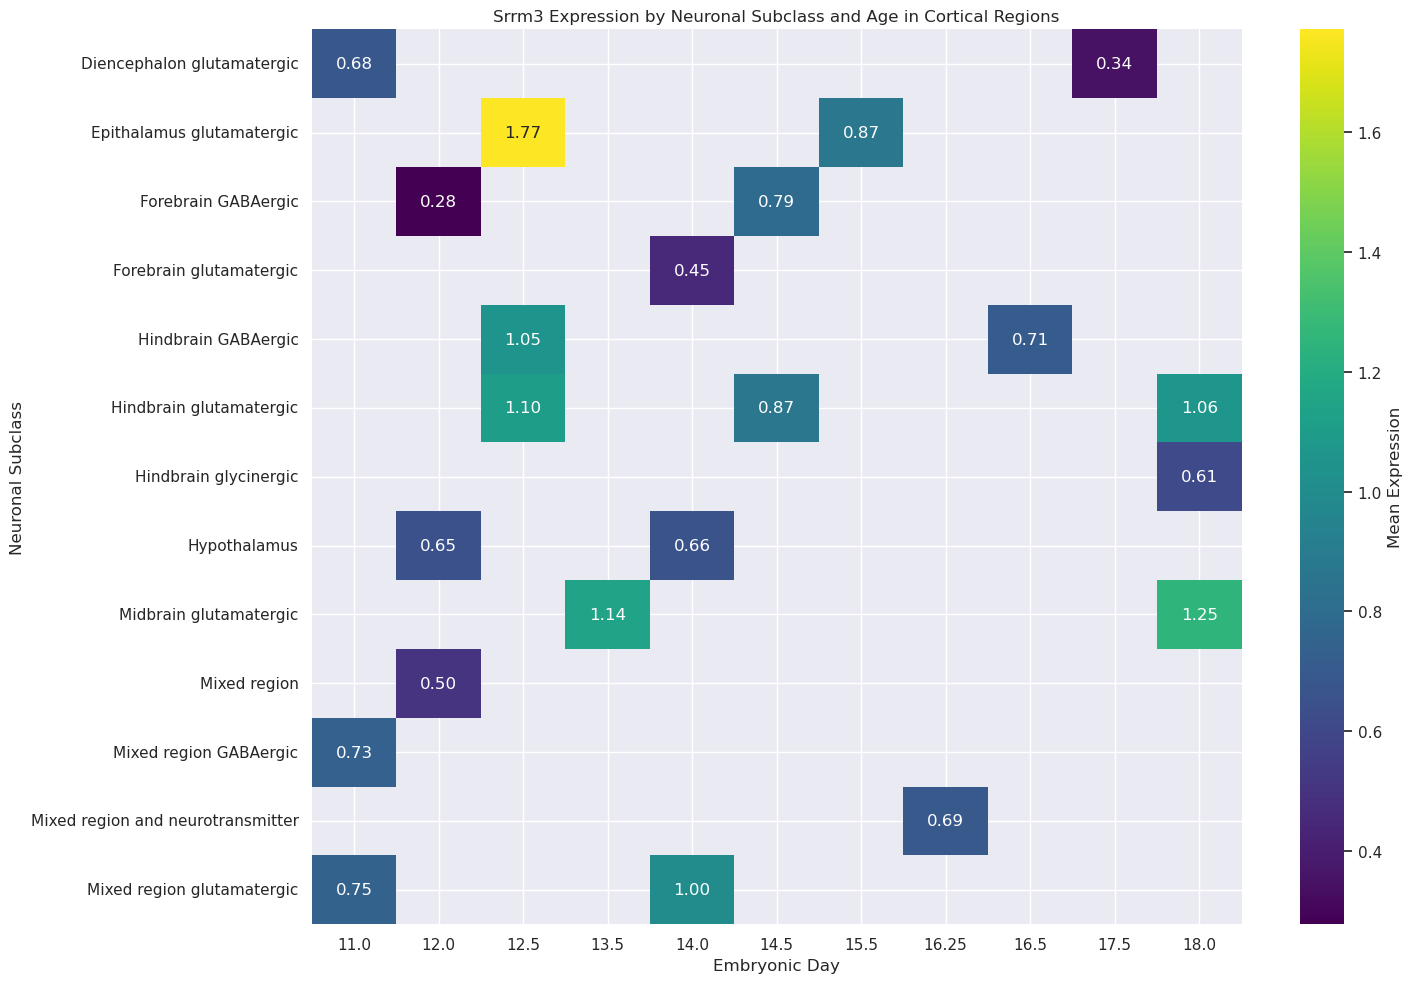

In [61]:
# Create heatmap of expression by age and neuronal subclass
pivot_df = df_neurons.pivot_table(
    values='Expression',
    index='Subclass',
    columns='Age',
    aggfunc='mean'
)

plt.figure(figsize=(15, 10))
sns.heatmap(pivot_df, cmap='viridis', annot=True, fmt='.2f', 
            cbar_kws={'label': 'Mean Expression'})
plt.title('Srrm3 Expression by Neuronal Subclass and Age in Cortical Regions')
plt.xlabel('Embryonic Day')
plt.ylabel('Neuronal Subclass')
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'srrm3_cortical_heatmap.pdf'), 
            bbox_inches='tight', dpi=300)
plt.savefig(os.path.join(plots_dir, 'srrm3_cortical_heatmap.png'), 
            bbox_inches='tight', dpi=300)
plt.show()

In [62]:
# Print summary statistics
print("\nSummary Statistics for Srrm3 Expression in Cortical Neuronal Lineages:")
print("\nBy Age and Class:")
summary_stats = df_neurons.groupby(['Age', 'Class'])['Expression'].describe()
print(summary_stats)

# Calculate the percentage of expressing cells in each class
print("\nPercentage of cells expressing Srrm3 (Expression > 0):")
expression_percentage = df_neurons.groupby('Class').agg({
    'Expression': lambda x: (x > 0).mean() * 100
}).round(2)
print(expression_percentage)


Summary Statistics for Srrm3 Expression in Cortical Neuronal Lineages:

By Age and Class:
              count      mean       std       min       25%       50%  \
Age   Class                                                             
11.00 Neuron    3.0  0.722491  0.033930  0.684211  0.709307  0.734403   
12.00 Neuron    4.0  0.425606  0.183914  0.238095  0.297476  0.408635   
12.50 Neuron    3.0  1.307977  0.402572  1.050992  1.076001  1.101010   
13.50 Neuron    1.0  1.142857       NaN  1.142857  1.142857  1.142857   
14.00 Neuron    3.0  0.702416  0.278644  0.447674  0.553624  0.659574   
14.50 Neuron    2.0  0.830201  0.052464  0.793103  0.811652  0.830201   
15.50 Neuron    1.0  0.868966       NaN  0.868966  0.868966  0.868966   
16.25 Neuron    1.0  0.689655       NaN  0.689655  0.689655  0.689655   
16.50 Neuron    1.0  0.707237       NaN  0.707237  0.707237  0.707237   
17.50 Neuron    1.0  0.344828       NaN  0.344828  0.344828  0.344828   
18.00 Neuron    3.0  0.973737  0.

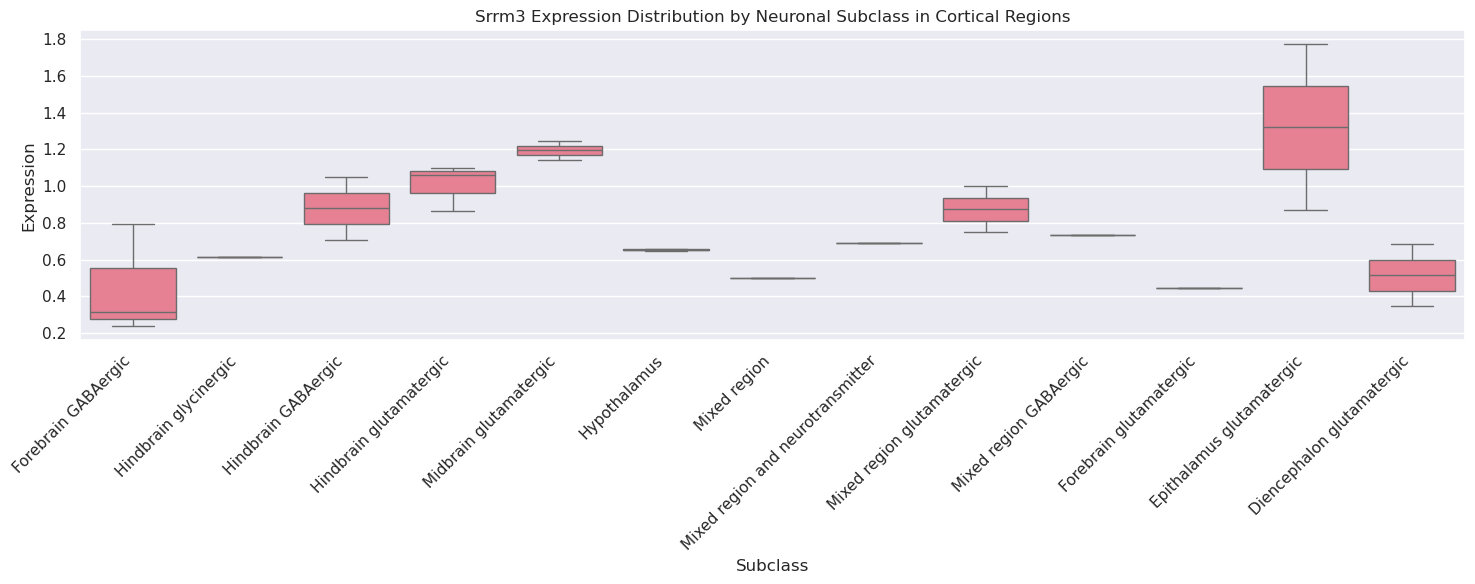

20038

In [63]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_neurons, x='Subclass', y='Expression')
plt.xticks(rotation=45, ha='right')
plt.title('Srrm3 Expression Distribution by Neuronal Subclass in Cortical Regions')
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'srrm3_cortical_boxplot.pdf'), 
            bbox_inches='tight', dpi=300)
plt.savefig(os.path.join(plots_dir, 'srrm3_cortical_boxplot.png'), 
            bbox_inches='tight', dpi=300)
plt.show()

# Save the summary statistics to a text file
with open(os.path.join(plots_dir, 'srrm3_cortical_statistics.txt'), 'w') as f:
    f.write("Summary Statistics for Srrm3 Expression in Cortical Neuronal Lineages:\n\n")
    f.write("By Age and Class:\n")
    f.write(summary_stats.to_string())
    f.write("\n\nPercentage of cells expressing Srrm3 (Expression > 0):\n")
    f.write(expression_percentage.to_string())

# Force garbage collection
gc.collect()